# Explore simulated relationship (part 2)

This notebook is using simulated data generated from [main_Pa_sim_enhance_AtoB](1_main_Pa_sim_enhance_AtoB.ipynb).  This notebook input raw Pseudomonas gene expression data from the Pseudomonas compendium referenced in [ADAGE](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5069748/) paper and added a strong nonlinear signal.  This signal assigned a set of genes to group A and a set of genes to group B.  If the expression of genes in group A exceeded some threshold then the genes in group B were upregulated.  

This notebook is extending from the exploration performed in [explore_relationship_AandB_pt1](explore_relationship_AandB_pt1.ipynb).  In this notebook we determined that the modeled/predicted gene expression data between A and B (i.e. after applying a linear transformation in the latent space and decoding) is a mostly linear relationship.  We assume that this means that the *decoder* is learning this linear relationship.  So now we want to determine what the *encoder* is learning. 

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import random
import glob
import seaborn as sns
from keras.models import model_from_json, load_model
from functions import utils
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

from numpy.random import seed
randomState = 123
seed(randomState)

Using TensorFlow backend.


In [2]:
# Run notebook to generate simulated data
#%run ./main_Pa_sim_enhance_AtoB.ipynb

In [3]:
# Load 
base_dir = os.path.dirname(os.getcwd())
analysis_name = 'sim_balancedAB_2latent'

sim_data_file = os.path.join(
    base_dir,
    "data",
    analysis_name,
    "train_model_input.txt.xz"
)

A_file = os.path.join(
    base_dir,
    "data",
    analysis_name,
    "geneSetA.txt"
)

B_file = os.path.join(
    base_dir,
    "data",
    analysis_name,
    "geneSetB.txt"
)

offset_vae_file = os.path.join(
    os.path.dirname(os.getcwd()), 
    "encoded",
    analysis_name, 
    "offset_latent_space_vae.txt"
)

weight_file = os.path.join(
    os.path.dirname(os.getcwd()),
    "data",
    analysis_name,
    "VAE_weight_matrix.txt"
)

model_encoder_file = glob.glob(os.path.join(
    base_dir,
    "models",
    analysis_name,
    "*_encoder_model.h5"))[0]

weights_encoder_file = glob.glob(
    os.path.join(
        base_dir,
        "models",
        analysis_name,
        "*_encoder_weights.h5"
    )
)[0]

model_decoder_file = glob.glob(
    os.path.join(
        base_dir,
        "models",
        analysis_name, 
        "*_decoder_model.h5"
    )
)[0]

weights_decoder_file = glob.glob(
    os.path.join(
        base_dir,
        "models", 
        analysis_name, 
        "*_decoder_weights.h5"
    )
)[0]

In [4]:
# Read data
sim_data = pd.read_table(sim_data_file, index_col=0, header=0, compression='xz')
geneSetA = pd.read_table(A_file, header=0, index_col=0)
geneSetB = pd.read_table(B_file, header=0, index_col=0)

print(sim_data.shape)
sim_data.head()

(1191, 2000)


,PA3423,PA0084,PA2455,PA3029,PA1588,PA2220,PA4656,PA3585,PA1325,PA3067,...,PA5348,PA4148,PA2158,PA2839,PA2410,PA0090,PA4963,PA3790,PA0969,PA4776
0.1_12hr_CSV86(Pae_G1a).CEL,0.45541,0.45541,0.45541,0.45541,0.45541,0.45541,0.45541,0.45541,0.45541,0.45541,...,0.039832,0.254100,0.30768,0.16118,0.37444,0.64132,0.359890,0.29978,0.47914,0.45004
0.1_2hr_CSV86(Pae_G1a).CEL,0.58208,0.58208,0.58208,0.58208,0.58208,0.58208,0.58208,0.58208,0.58208,0.58208,...,0.349910,0.619100,0.40616,0.23314,0.77043,0.27328,0.065203,0.97198,0.20305,0.29230
0.1_6hr_CSV86(Pae_G1a).CEL,0.24626,0.24626,0.24626,0.24626,0.24626,0.24626,0.24626,0.24626,0.24626,0.24626,...,0.030076,0.031428,0.52120,0.49219,0.52767,0.35445,0.307290,0.38095,0.34503,0.14212
0.1_7hr_CSV86(Pae_G1a).CEL,0.75444,0.75444,0.75444,0.75444,0.75444,0.75444,0.75444,0.75444,0.75444,0.75444,...,0.416210,0.390080,0.45683,0.46744,0.54591,0.47546,0.440540,0.63655,0.42038,0.21466
0.1_9hr_CSV86(Pae_G1a).CEL,0.25606,0.25606,0.25606,0.25606,0.25606,0.25606,0.25606,0.25606,0.25606,0.25606,...,0.022703,0.132680,0.24480,0.44281,0.41727,0.42175,0.214940,0.36677,0.43960,0.26945


In [5]:
# Select samples that have expression of gene A around the threshold 
# Since threshold is 0.5 then select samples with expression in range(0.4, 0.6)

# Since our simulation set all genes in set A to be the same value for a give sample
# we can consider a single gene in set A to query by
rep_gene_A = geneSetA.iloc[0][0]

# Query for samples whose representative gene A expression is in range (0.4, 0.6)
#test_samples = sim_data.query('0.4 < @rep_gene_A < 0.6') -- why didn't this work?
test_samples = sim_data[(sim_data[rep_gene_A]>0.4) & (sim_data[rep_gene_A]<0.6)]

test_samples_sorted = test_samples.sort_values(by=[rep_gene_A])

print(test_samples_sorted.shape)
test_samples_sorted.head()

(249, 2000)


,PA3423,PA0084,PA2455,PA3029,PA1588,PA2220,PA4656,PA3585,PA1325,PA3067,...,PA5348,PA4148,PA2158,PA2839,PA2410,PA0090,PA4963,PA3790,PA0969,PA4776
GSM591601.CEL,0.40003,0.40003,0.40003,0.40003,0.40003,0.40003,0.40003,0.40003,0.40003,0.40003,...,0.60707,0.136710,0.15389,0.14460,0.67047,0.34323,0.37717,0.60430,0.58534,0.38804
GSM155239.CEL,0.40023,0.40023,0.40023,0.40023,0.40023,0.40023,0.40023,0.40023,0.40023,0.40023,...,0.74535,0.124810,0.15990,0.11783,0.38921,0.54921,0.44748,0.71622,0.67001,0.21556
GSM821500.CEL,0.40030,0.40030,0.40030,0.40030,0.40030,0.40030,0.40030,0.40030,0.40030,0.40030,...,0.87365,0.250260,0.28125,0.12586,0.71521,0.35301,0.28672,0.62467,0.69961,0.46257
JS-A84.9.07.CEL,0.40338,0.40338,0.40338,0.40338,0.40338,0.40338,0.40338,0.40338,0.40338,0.40338,...,0.37184,0.316720,0.28475,0.53204,0.33607,0.39655,0.23759,0.42177,0.22861,0.22927
GSM2070507_OCio-12-MutS-B-Cip-D94-3-Pae_G1a-a1.CEL,0.40368,0.40368,0.40368,0.40368,0.40368,0.40368,0.40368,0.40368,0.40368,0.40368,...,0.59531,0.084455,0.15297,0.18333,0.30265,0.22275,0.37615,0.68975,0.70133,0.26638


## 1. Trend of gene B with respect to A (input)

How is B changing with respect to A in our simulated dataset (before the data goes into the autoencoder)?

Plot gene expression of A vs mean(gene B expression).  This plot will serve as a reference against later plots that will show the relationship between A and B after transforming the data (i.e. after the data has been fed through the autoencoder)

In [6]:
# Get the means of B genes

# Convert dataframe with gene ids to list
geneSetB_ls = geneSetB['gene id'].values.tolist()

geneSetB_exp = test_samples[geneSetB_ls]

# Get the mean for each sample
geneSetB_mean = geneSetB_exp.mean(axis=1)
geneSetB_mean.head()

0.1_12hr_CSV86(Pae_G1a).CEL       0.381348
0.1_2hr_CSV86(Pae_G1a).CEL        0.542299
1_6hr_CSV86(Pae_G1a).CEL          0.376520
120330-10978D_24_(Pae_G1a).CEL    0.417676
120330-10978D_M1_(Pae_G1a).CEL    0.418785
dtype: float64

In [7]:
# Join original expression of A and mean(transformed expression of B)
original_A_exp = test_samples[rep_gene_A]
original_B_mean_exp = geneSetB_mean

A_and_B_before_df = pd.merge(original_A_exp.to_frame('gene A untransformed'),
                      original_B_mean_exp.to_frame('mean gene B untransformed'),
                      left_index=True, right_index=True)
A_and_B_before_df.head()

,gene A untransformed,mean gene B untransformed
0.1_12hr_CSV86(Pae_G1a).CEL,0.45541,0.381348
0.1_2hr_CSV86(Pae_G1a).CEL,0.58208,0.542299
1_6hr_CSV86(Pae_G1a).CEL,0.45123,0.376520
120330-10978D_24_(Pae_G1a).CEL,0.46853,0.417676
120330-10978D_M1_(Pae_G1a).CEL,0.40628,0.418785


**Plot**
The plot below shows the signal that was added to the dataset.  This signal assigned a set of genes to group A and a set of genes to group B. If the expression of genes in group A exceeded some threshold then the genes in group B were upregulated.  

So we see a step function relationship between the expression of genes in group A and the expression of genes in group B.  With a threshold of 0.5 we can see that the expression of genes in B are upregulated.

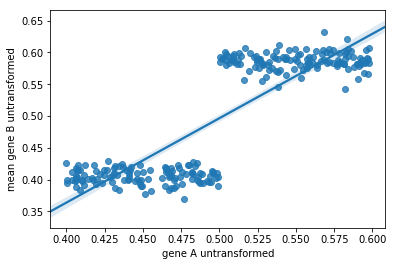

In [8]:
# Plot
sns.regplot(x='gene A untransformed',
            y='mean gene B untransformed',
           data = A_and_B_before_df)

## 2.  Trend of gene B with respect to A (decoder)

How is B changing with respect to A after applying our latent space transformation?

Here we are only changing samples **after** they have been encoded into the latent space and we apply our latent space transformation.  Therefore, any trends that we observe we conclude that this relationship is what the decoder is learning.

In [9]:
# Define function to apply latent space transformation and output reconstructed data

def interpolate_in_vae_latent_space_AB(all_data, 
                                       sample_data,
                                       model_encoder_file,
                                       model_decoder_file,
                                       weights_encoder_file,
                                       weights_decoder_file,
                                       encoded_dir,
                                       gene_id,
                                       percent_low,
                                       percent_high,
                                       out_dir):
    """
    interpolate_in_vae_latent_space(all_data: dataframe,
                                    sample_data: dataframe,
                                    model_encoder_file: string,
                                    model_decoder_file: string,
                                    weights_encoder_file: string,
                                    weights_decoder_file: string,
                                    encoded_dir: string,
                                    gene_id: string,
                                    percent_low: integer,
                                    percent_high: integer,
                                    out_dir: string):

    input:
        all_data: Dataframe with gene expression data from all samples
        
        sample_data:  Dataframe with gene expression data from subset of samples (around the treshold)

        model_encoder_file: file containing the learned vae encoder model

        model_decoder_file: file containing the learned vae decoder model
        
        weights_encoder_file: file containing the learned weights associated with the vae encoder model
        
        weights_decoder_file: file containing the learned weights associated with the vae decoder model
        
        encoded_dir:  directory to use to output offset vector to 

        gene_id: gene you are using as the "phenotype" to sort samples by 

                 This gene is referred to as "target_gene" in comments below


        percent_low: integer between 0 and 1

        percent_high: integer between 0 and 1
        
        out_dir: directory to output predicted gene expression to

    computation:
        1.  Sort samples based on the expression level of the target gene defined by the user
        2.  Sample_data are encoded into VAE latent space
        3.  We predict the expression profile of the OTHER genes at a given level of target gene 
            expression by adding a scale factor of offset vector to the sample

            The scale factor depends on the distance along the target gene expression gradient
            the sample is.  For example the range along the target gene expression is from 0 to 1.  
            If the sample of interest has a target gene expression of 0.3 then our prediction
            for the gene expression of all other genes is equal to the gene expression corresponding
            to the target gene expression=0 + 0.3*offset latent vector
        3.  Prediction is decoded back into gene space
        4.  This computation is repeated for all samples 

    output: 
         1. encoded predicted expression profile per sample
         2. predicted expression profile per sample

    """

    # Load arguments
    offset_file = os.path.join(encoded_dir, "offset_latent_space_vae.txt")

    # Output file
    predict_file = os.path.join(out_dir, "predicted_gene_exp.txt")
    predict_encoded_file = os.path.join(out_dir, "predicted_encoded_gene_exp.txt")

    # Read in data
    target_gene_data = all_data[gene_id]
    offset_encoded = pd.read_table(offset_file, header=0, index_col=0)    
    
    # read in saved VAE models
    loaded_model = load_model(model_encoder_file)
    loaded_decoder_model = load_model(model_decoder_file)

    # load weights into models
    loaded_model.load_weights(weights_encoder_file)
    loaded_decoder_model.load_weights(weights_decoder_file)
    
    # Sort target gene data by expression (lowest --> highest)
    target_gene_sorted = target_gene_data.sort_values()

    lowest_file = os.path.join(encoded_dir, "lowest_encoded_vae.txt")
    low_exp_encoded = pd.read_table(lowest_file, header=0, index_col=0)
    
    # Average gene expression across samples in each extreme group
    lowest_mean_encoded = low_exp_encoded.mean(axis=0)

    # Format and rename as "baseline"
    baseline_encoded = pd.DataFrame(
        lowest_mean_encoded, index=offset_encoded.columns).T
    
    # Initialize dataframe for predicted expression of sampled data
    predicted_sample_data = pd.DataFrame(columns=sample_data.columns)
    predicted_encoded_sample_data = pd.DataFrame()
    
    sample_ids = sample_data.index
    for sample_id in sample_ids:
        intermediate_target_gene_exp = target_gene_sorted[sample_id]
        print('gene A exp is {}'.format(intermediate_target_gene_exp))
        alpha = get_scale_factor(
            target_gene_sorted, intermediate_target_gene_exp, percent_low, percent_high)
        print('scale factor is {}'.format(alpha))
        predict = baseline_encoded + alpha * offset_encoded

        predict_encoded_df = pd.DataFrame(predict)
        
        predicted_encoded_sample_data = (
            predicted_encoded_sample_data
            .append(predict_encoded_df, ignore_index=True)
        )
        
        # Decode prediction
        predict_decoded = loaded_decoder_model.predict_on_batch(predict)
        
        predict_df = pd.DataFrame(
            predict_decoded, columns=sample_data.columns)
        
        predicted_sample_data = (
            predicted_sample_data
            .append(predict_df, ignore_index=True)
        )

    predicted_sample_data.set_index(sample_data.index, inplace=True)
    predicted_encoded_sample_data.set_index(sample_data.index, inplace=True)
    
    # Output estimated gene experession values
    predicted_sample_data.to_csv(predict_file, sep='\t')
    predicted_encoded_sample_data.to_csv(predict_encoded_file, sep='\t')
    
def get_scale_factor(target_gene_sorted, expression_profile,
                     percent_low, percent_high):
    """
    get_scale_factor(target_gene_sorted: dataframe,
                    expression_profile: dataframe,
                    percent_low: integer,
                    percent_high: integer,):

    input:
        target_gene_sorted: dataframe of sorted target gene expression

        expression_profile: dataframe of gene expression for selected sample

        percent_low: integer between 0 and 1

        percent_high: integer between 0 and 1

    computation:
        Determine how much to scale offset based on distance along the target gene expression gradient

    Output:
     scale factor = intermediate gene expression/ (average high target gene expression - avgerage low target gene expression) 
    """

    # Collect the extreme gene expressions
    # Get sample IDs with the lowest 5% of reference gene expression
    threshold_low = np.percentile(target_gene_sorted, percent_low)
    lowest = target_gene_sorted[target_gene_sorted <= threshold_low]

    # Get sample IDs with the highest 5% of reference gene expression
    threshold_high = np.percentile(target_gene_sorted, percent_high)
    highest = target_gene_sorted[target_gene_sorted >= threshold_high]

    # Average gene expression across samples in each extreme group
    lowest_mean = (lowest.values).mean()
    highest_mean = (highest.values).mean()

    # Different in extremes
    denom = highest_mean - lowest_mean

    # scale_factor is the proportion along the gene expression gradient
    scale_factor = expression_profile / denom

    return scale_factor

In [10]:
# Apply function 
out_dir = os.path.join(base_dir, "output", analysis_name)
encoded_dir = os.path.join(base_dir, "encoded", analysis_name)

percent_low = 5
percent_high = 95
interpolate_in_vae_latent_space_AB(sim_data,
                                   test_samples_sorted,
                                   model_encoder_file,
                                   model_decoder_file,
                                   weights_encoder_file,
                                   weights_decoder_file,
                                   encoded_dir,
                                   rep_gene_A,
                                   percent_low,
                                   percent_high,
                                   out_dir)

/home/alexandra/anaconda3/envs/Pa/lib/python3.5/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


gene A exp is 0.40003
scale factor is 0.4265213848918175
gene A exp is 0.40023000000000003
scale factor is 0.426734629590911
gene A exp is 0.4003
scale factor is 0.42680926523559365
gene A exp is 0.40338
scale factor is 0.43009323360163326
gene A exp is 0.40368000000000004
scale factor is 0.4304131006502735
gene A exp is 0.40571
scale factor is 0.43257753434607227
gene A exp is 0.406
scale factor is 0.4328867391597578
gene A exp is 0.40619
scale factor is 0.4330893216238966
gene A exp is 0.40628000000000003
scale factor is 0.4331852817384887
gene A exp is 0.40631999999999996
scale factor is 0.4332279306783073
gene A exp is 0.40639000000000003
scale factor is 0.4333025663229901
gene A exp is 0.40663
scale factor is 0.43355845996190223
gene A exp is 0.40684000000000003
scale factor is 0.4337823668959504
gene A exp is 0.40741
scale factor is 0.43439011428836677
gene A exp is 0.40786999999999995
scale factor is 0.43488057709628175
gene A exp is 0.40883
scale factor is 0.43590415165193047
g

scale factor is 0.5751209534551067
gene A exp is 0.54171
scale factor is 0.5775839297296365
gene A exp is 0.5428
scale factor is 0.5787461133396958
gene A exp is 0.54337
scale factor is 0.5793538607321123
gene A exp is 0.54356
scale factor is 0.5795564431962511
gene A exp is 0.54357
scale factor is 0.5795671054312057
gene A exp is 0.54579
scale factor is 0.5819341215911433
gene A exp is 0.54581
scale factor is 0.5819554460610527
gene A exp is 0.54848
scale factor is 0.5848022627939505
gene A exp is 0.5492600000000001
scale factor is 0.5856339171204152
gene A exp is 0.54935
scale factor is 0.5857298772350072
gene A exp is 0.5504399999999999
scale factor is 0.5868920608450666
gene A exp is 0.55143
scale factor is 0.5879476221055794
gene A exp is 0.55253
scale factor is 0.5891204679505935
gene A exp is 0.55292
scale factor is 0.5895362951138258
gene A exp is 0.55301
scale factor is 0.5896322552284179
gene A exp is 0.55488
scale factor is 0.5916260931649419
gene A exp is 0.55657
scale fact

**Plot**
Plot transformed gene expression A vs mean transformed expression of genes in set B

Q: What is the relationship between genes in set A and B?  As the expression of A varies how does the expression of B vary?

In [11]:
# Read dataframe with gene expression transformed
predict_file = os.path.join(base_dir, "output", analysis_name, "predicted_gene_exp.txt")
predict_gene_exp = pd.read_table(predict_file, header=0, index_col=0)

print(predict_gene_exp.shape)
predict_gene_exp.head()

(249, 2000)


,PA3423,PA0084,PA2455,PA3029,PA1588,PA2220,PA4656,PA3585,PA1325,PA3067,...,PA5348,PA4148,PA2158,PA2839,PA2410,PA0090,PA4963,PA3790,PA0969,PA4776
GSM591601.CEL,0.583304,0.584206,0.582102,0.583978,0.584106,0.584931,0.583052,0.583263,0.582769,0.580653,...,0.766036,0.248253,0.399361,0.279730,0.570046,0.570329,0.638911,0.504831,0.745608,0.487350
GSM155239.CEL,0.583499,0.584399,0.582295,0.584171,0.584299,0.585128,0.583247,0.583458,0.582965,0.580849,...,0.766091,0.248301,0.399427,0.279781,0.570117,0.570385,0.638969,0.504883,0.745665,0.487394
GSM821500.CEL,0.583567,0.584466,0.582363,0.584239,0.584367,0.585197,0.583315,0.583526,0.583034,0.580918,...,0.766110,0.248318,0.399450,0.279798,0.570142,0.570405,0.638990,0.504901,0.745685,0.487409
JS-A84.9.07.CEL,0.586564,0.587429,0.585331,0.587209,0.587339,0.588225,0.586318,0.586517,0.586048,0.583934,...,0.766955,0.249050,0.400463,0.280577,0.571247,0.571268,0.639891,0.505702,0.746566,0.488089
GSM2070507_OCio-12-MutS-B-Cip-D94-3-Pae_G1a-a1.CEL,0.586856,0.587718,0.585620,0.587498,0.587628,0.588519,0.586610,0.586808,0.586342,0.584228,...,0.767038,0.249121,0.400561,0.280653,0.571354,0.571352,0.639979,0.505780,0.746651,0.488156


In [12]:
# Get the means of B genes

# Convert dataframe with gene ids to list
geneSetB_ls = geneSetB['gene id'].values.tolist()

geneSetB_exp = predict_gene_exp[geneSetB_ls]

# Get the mean for each sample
geneSetB_mean = geneSetB_exp.mean(axis=1)
geneSetB_mean.head()

GSM591601.CEL                                         0.531611
GSM155239.CEL                                         0.531671
GSM821500.CEL                                         0.531692
JS-A84.9.07.CEL                                       0.532607
GSM2070507_OCio-12-MutS-B-Cip-D94-3-Pae_G1a-a1.CEL    0.532696
dtype: float64

In [13]:
# Join original expression of transformed A and mean(transformed expression of B)
predict_A_exp = predict_gene_exp[rep_gene_A]
predict_B_mean_exp = geneSetB_mean

A_and_B_predict_df = pd.merge(predict_A_exp.to_frame('gene A transformed'),
                      predict_B_mean_exp.to_frame('mean gene B transformed'),
                      left_index=True, right_index=True)
A_and_B_predict_df.head()

,gene A transformed,mean gene B transformed
GSM591601.CEL,0.583304,0.531611
GSM155239.CEL,0.583499,0.531671
GSM821500.CEL,0.583567,0.531692
JS-A84.9.07.CEL,0.586564,0.532607
GSM2070507_OCio-12-MutS-B-Cip-D94-3-Pae_G1a-a1.CEL,0.586856,0.532696


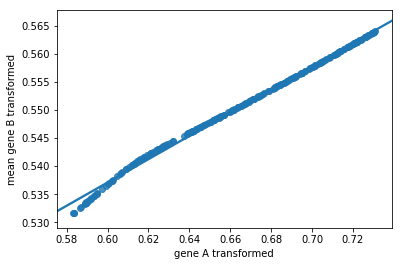

In [14]:
# Plot
sns.regplot(x='gene A transformed',
            y='mean gene B transformed',
           data = A_and_B_predict_df)

## 3.  Trend of gene B with respect to A (encoder)

How is B changing with respect to A after shifting input expression and then applying our latent space transformation?

Here we are only changing samples **before** they have been encoded into the latent space and then we apply our latent space transformation.  If we compare these trends with those from #2 module, which show what the decoder is supposedly learning, then we can conclude what the encoder is learning.

In order to test this we manually shift A genes from being below the activation threshold to being above it and see how the gene expression data is reconstructed

In [15]:
# Artificially shift gene A expression

# Get single sample
test_sample = test_samples_sorted.index[0]
print(test_sample)

# Sample with original value of gene A
A_exp_sample = test_samples_sorted.loc[test_sample]

A_exp_sample_modified_df = pd.DataFrame()

A_exp_sample_modified_df.append(A_exp_sample, ignore_index=True)

# Convert dataframe with gene ids to list
geneSetA_ls = geneSetA['gene id'].values.tolist()

# Artificially shift genes in set A
new_A_exp = np.linspace(0.41, 0.60, num=100)

for i in new_A_exp:
    test_samples_sorted.loc[test_sample,geneSetA_ls] = i
    A_exp_sample = test_samples_sorted.loc[test_sample]
    A_exp_sample_modified_df = A_exp_sample_modified_df.append(A_exp_sample, ignore_index=True)

A_exp_sample_modified_df.head()

GSM591601.CEL


,PA0002,PA0003,PA0007,PA0009,PA0010,PA0014,PA0015,PA0017,PA0019,PA0020,...,PA5543,PA5544,PA5552,PA5554,PA5556,PA5560,PA5565,PA5566,PA5567,PA5568
0,0.410000,0.410000,0.31114,0.57509,0.410000,0.410000,0.34458,0.410000,0.410000,0.410000,...,0.33783,0.410000,0.410000,0.80794,0.410000,0.410000,0.66961,0.18282,0.6835,0.66566
1,0.411919,0.411919,0.31114,0.57509,0.411919,0.411919,0.34458,0.411919,0.411919,0.411919,...,0.33783,0.411919,0.411919,0.80794,0.411919,0.411919,0.66961,0.18282,0.6835,0.66566
2,0.413838,0.413838,0.31114,0.57509,0.413838,0.413838,0.34458,0.413838,0.413838,0.413838,...,0.33783,0.413838,0.413838,0.80794,0.413838,0.413838,0.66961,0.18282,0.6835,0.66566
3,0.415758,0.415758,0.31114,0.57509,0.415758,0.415758,0.34458,0.415758,0.415758,0.415758,...,0.33783,0.415758,0.415758,0.80794,0.415758,0.415758,0.66961,0.18282,0.6835,0.66566
4,0.417677,0.417677,0.31114,0.57509,0.417677,0.417677,0.34458,0.417677,0.417677,0.417677,...,0.33783,0.417677,0.417677,0.80794,0.417677,0.417677,0.66961,0.18282,0.6835,0.66566


In [16]:
# Define function to apply latent space transformation to SHIFTED data and output reconstructed data

def interpolate_in_vae_latent_space_shiftA(all_data, 
                                       sample_data,
                                       model_encoder_file,
                                       model_decoder_file,
                                       weights_encoder_file,
                                       weights_decoder_file,
                                       encoded_dir,
                                       gene_id,
                                       percent_low,
                                       percent_high,
                                       out_dir):
    """
    interpolate_in_vae_latent_space(all_data: dataframe,
                                    sample_data: dataframe,
                                    model_encoder_file: string,
                                    model_decoder_file: string,
                                    weights_encoder_file: string,
                                    weights_decoder_file: string,
                                    encoded_dir: string,
                                    gene_id: string,
                                    percent_low: integer,
                                    percent_high: integer,
                                    out_dir: string):

    input:
        all_data: Dataframe with gene expression data from all samples
        
        sample_data:  Dataframe with gene expression data from subset of samples (around the treshold)

        model_encoder_file: file containing the learned vae encoder model

        model_decoder_file: file containing the learned vae decoder model
        
        weights_encoder_file: file containing the learned weights associated with the vae encoder model
        
        weights_decoder_file: file containing the learned weights associated with the vae decoder model
        
        encoded_dir:  directory to use to output offset vector to 

        gene_id: gene you are using as the "phenotype" to sort samples by 

                 This gene is referred to as "target_gene" in comments below


        percent_low: integer between 0 and 1

        percent_high: integer between 0 and 1
        
        out_dir: directory to output predicted gene expression to

    computation:
        1.  Sort samples based on the expression level of the target gene defined by the user
        2.  Sample_data are encoded into VAE latent space
        3.  We predict the expression profile of the OTHER genes at a given level of target gene 
            expression by adding a scale factor of offset vector to the sample

            The scale factor depends on the distance along the target gene expression gradient
            the sample is.  For example the range along the target gene expression is from 0 to 1.  
            If the sample of interest has a target gene expression of 0.3 then our prediction
            for the gene expression of all other genes is equal to the gene expression corresponding
            to the target gene expression=0 + 0.3*offset latent vector
        3.  Prediction is decoded back into gene space
        4.  This computation is repeated for all samples 

    output: 
         1. encoded predicted expression profile per sample
         2. predicted expression profile per sample

    """

    # Load arguments
    offset_file = os.path.join(encoded_dir, "offset_latent_space_vae.txt")

    # Output file
    predict_file = os.path.join(out_dir, "shifted_predicted_gene_exp.txt")
    predict_encoded_file = os.path.join(out_dir, "shifted_predicted_encoded_gene_exp.txt")

    # Read in data
    target_gene_data = all_data[gene_id]
    offset_encoded = pd.read_table(offset_file, header=0, index_col=0)    
    
    # read in saved VAE models
    loaded_model = load_model(model_encoder_file)
    loaded_decoder_model = load_model(model_decoder_file)

    # load weights into models
    loaded_model.load_weights(weights_encoder_file)
    loaded_decoder_model.load_weights(weights_decoder_file)
    
    # Initialize dataframe for predicted expression of sampled data
    predicted_sample_data = pd.DataFrame(columns=sample_data.columns)
    predicted_encoded_sample_data = pd.DataFrame()
    
    sample_ids = sample_data.index
    for sample_id in sample_ids:
        sample_exp = sample_data.loc[sample_id].to_frame().T
        
        # Use trained model to encode expression data into SAME latent space
        predict = loaded_model.predict_on_batch(sample_exp)

        predict_encoded_df = pd.DataFrame(predict)
        
        predicted_encoded_sample_data = (
            predicted_encoded_sample_data
            .append(predict_encoded_df, ignore_index=True)
        )
        
        # Decode prediction
        predict_decoded = loaded_decoder_model.predict_on_batch(predict_encoded_df)
        predict_df = pd.DataFrame(
            predict_decoded, columns=sample_data.columns)
        
        predicted_sample_data = (
            predicted_sample_data
            .append(predict_df, ignore_index=True)
        )

    predicted_sample_data.set_index(sample_data.index, inplace=True)
    predicted_encoded_sample_data.set_index(sample_data.index, inplace=True)
    
    # Output estimated gene experession values
    predicted_sample_data.to_csv(predict_file, sep='\t')
    predicted_encoded_sample_data.to_csv(predict_encoded_file, sep='\t')

In [17]:
# Apply function 
out_dir = os.path.join(base_dir, "output", analysis_name)
encoded_dir = os.path.join(base_dir, "encoded", analysis_name)

percent_low = 5
percent_high = 95
interpolate_in_vae_latent_space_shiftA(sim_data,
                                   A_exp_sample_modified_df,
                                   model_encoder_file,
                                   model_decoder_file,
                                   weights_encoder_file,
                                   weights_decoder_file,
                                   encoded_dir,
                                   rep_gene_A,
                                   percent_low,
                                   percent_high,
                                   out_dir)

/home/alexandra/anaconda3/envs/Pa/lib/python3.5/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [18]:
# Read dataframe with gene expression transformed
predict_file = os.path.join(base_dir, "output", analysis_name, "shifted_predicted_gene_exp.txt")
predict_gene_exp = pd.read_table(predict_file, header=0, index_col=0)

print(predict_gene_exp.shape)
predict_gene_exp.head()

(100, 2000)


,PA0002,PA0003,PA0007,PA0009,PA0010,PA0014,PA0015,PA0017,PA0019,PA0020,...,PA5543,PA5544,PA5552,PA5554,PA5556,PA5560,PA5565,PA5566,PA5567,PA5568
0,0.249463,0.252477,0.252138,0.249553,0.251922,0.248631,0.250298,0.252343,0.249776,0.250093,...,0.631356,0.170033,0.288164,0.202728,0.436526,0.460013,0.517893,0.407094,0.610456,0.402773
1,0.249463,0.252477,0.252138,0.249553,0.251922,0.248631,0.250298,0.252343,0.249776,0.250093,...,0.631356,0.170033,0.288164,0.202728,0.436526,0.460013,0.517893,0.407094,0.610456,0.402773
2,0.249370,0.252403,0.252012,0.249440,0.251810,0.248533,0.250199,0.252269,0.249644,0.249987,...,0.631435,0.170144,0.288370,0.202786,0.436656,0.460054,0.517965,0.407203,0.610418,0.402789
3,0.249350,0.252324,0.251890,0.249355,0.251737,0.248526,0.250180,0.252183,0.249509,0.249909,...,0.631564,0.170389,0.288761,0.202886,0.436918,0.460109,0.518080,0.407415,0.610301,0.402754
4,0.249374,0.252262,0.251805,0.249300,0.251704,0.248561,0.250200,0.252114,0.249408,0.249857,...,0.631686,0.170643,0.289156,0.202981,0.437183,0.460157,0.518176,0.407628,0.610172,0.402699


In [19]:
# Get the means of B genes

# Convert dataframe with gene ids to list
geneSetB_ls = geneSetB['gene id'].values.tolist()

geneSetB_exp = predict_gene_exp[geneSetB_ls]

# Get the mean for each sample
geneSetB_transformed_mean = geneSetB_exp.mean(axis=1)
geneSetB_transformed_mean.head()

0    0.337821
1    0.337821
2    0.337824
3    0.337888
4    0.337967
dtype: float64

**Plot:** Original A vs Transformed A

In [20]:
# Join original expression of A and transformed expression of A
original_A_exp = A_exp_sample_modified_df[rep_gene_A]
predict_A_exp = predict_gene_exp[rep_gene_A]

original_A_vs_transformed_A_df = pd.merge(original_A_exp.to_frame('gene A untransformed'),
                      predict_A_exp.to_frame('gene A transformed'),
                      left_index=True, right_index=True)

original_A_vs_transformed_A_df.head()

,gene A untransformed,gene A transformed
0,0.410000,0.339107
1,0.411919,0.339107
2,0.413838,0.339207
3,0.415758,0.339399
4,0.417677,0.339590


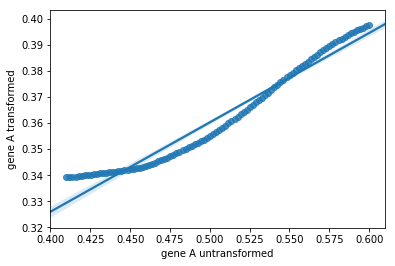

In [21]:
# Plot
sns.regplot(x='gene A untransformed',
            y='gene A transformed',
           data = original_A_vs_transformed_A_df)

**Plot:** Original A vs Mean(Transformed B)

In [22]:
# Join original expression of A and mean(transformed expression of B)
original_A_exp = A_exp_sample_modified_df[rep_gene_A]
predict_B_mean_exp = geneSetB_transformed_mean

original_A_vs_transformed_B_df = pd.merge(original_A_exp.to_frame('gene A untransformed'),
                      predict_B_mean_exp.to_frame('mean gene B transformed'),
                      left_index=True, right_index=True)

original_A_vs_transformed_B_df.head()

,gene A untransformed,mean gene B transformed
0,0.410000,0.337821
1,0.411919,0.337821
2,0.413838,0.337824
3,0.415758,0.337888
4,0.417677,0.337967


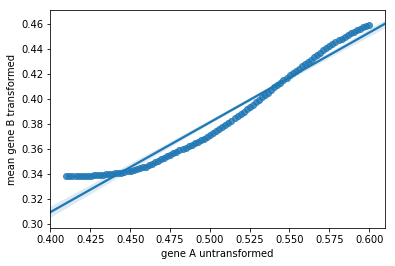

In [23]:
# Plot
# A before transformation vs B after transformation
sns.regplot(x='gene A untransformed',
            y='mean gene B transformed',
           data = original_A_vs_transformed_B_df)

**Plot:** Transformed A vs Mean(Transformed B)

In [24]:
# Join original expression of transformed A and mean(transformed expression of B)
predict_A_exp = predict_gene_exp[rep_gene_A]
predict_B_mean_exp = geneSetB_transformed_mean

A_and_B_predict_df = pd.merge(predict_A_exp.to_frame('gene A transformed'),
                      predict_B_mean_exp.to_frame('mean gene B transformed'),
                      left_index=True, right_index=True)
A_and_B_predict_df.head()

,gene A transformed,mean gene B transformed
0,0.339107,0.337821
1,0.339107,0.337821
2,0.339207,0.337824
3,0.339399,0.337888
4,0.339590,0.337967


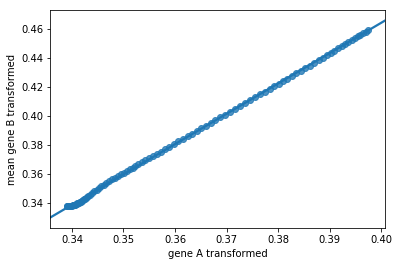

In [25]:
# Plot
sns.regplot(x='gene A transformed',
            y='mean gene B transformed',
           data = A_and_B_predict_df)

## 4.  Trend of gene B with respect to A (encoder)

We will perform the same analysis as before but this time we will manually shift B genes from being below the activation threshold to being above it and see how the gene expression data is reconstructed

In [26]:
# Artificially shift gene B expression

# Get single sample
test_sample = test_samples_sorted.index[0]
print(test_sample)

# Sample with original value of gene A
A_exp_sample = test_samples_sorted.loc[test_sample]

A_exp_sample_modified_df = pd.DataFrame()

A_exp_sample_modified_df.append(A_exp_sample, ignore_index=True)

# Convert dataframe with gene ids to list
geneSetA_ls = geneSetA['gene id'].values.tolist()

# Artificially shift genes in set A
new_A_exp = np.linspace(0.41, 0.60, num=100)

for i in new_A_exp:
    test_samples_sorted.loc[test_sample,geneSetA_ls] = i
    A_exp_sample = test_samples_sorted.loc[test_sample]
    A_exp_sample_modified_df = A_exp_sample_modified_df.append(A_exp_sample, ignore_index=True)

A_exp_sample_modified_df.head()

GSM591601.CEL


,PA0002,PA0003,PA0007,PA0009,PA0010,PA0014,PA0015,PA0017,PA0019,PA0020,...,PA5543,PA5544,PA5552,PA5554,PA5556,PA5560,PA5565,PA5566,PA5567,PA5568
0,0.410000,0.410000,0.31114,0.57509,0.410000,0.410000,0.34458,0.410000,0.410000,0.410000,...,0.33783,0.410000,0.410000,0.80794,0.410000,0.410000,0.66961,0.18282,0.6835,0.66566
1,0.411919,0.411919,0.31114,0.57509,0.411919,0.411919,0.34458,0.411919,0.411919,0.411919,...,0.33783,0.411919,0.411919,0.80794,0.411919,0.411919,0.66961,0.18282,0.6835,0.66566
2,0.413838,0.413838,0.31114,0.57509,0.413838,0.413838,0.34458,0.413838,0.413838,0.413838,...,0.33783,0.413838,0.413838,0.80794,0.413838,0.413838,0.66961,0.18282,0.6835,0.66566
3,0.415758,0.415758,0.31114,0.57509,0.415758,0.415758,0.34458,0.415758,0.415758,0.415758,...,0.33783,0.415758,0.415758,0.80794,0.415758,0.415758,0.66961,0.18282,0.6835,0.66566
4,0.417677,0.417677,0.31114,0.57509,0.417677,0.417677,0.34458,0.417677,0.417677,0.417677,...,0.33783,0.417677,0.417677,0.80794,0.417677,0.417677,0.66961,0.18282,0.6835,0.66566


**Plot:** Mean(Untransformed B) vs Mean(Transformed B)

In [27]:
# Get the means of B genes

# Convert dataframe with gene ids to list
geneSetB_ls = geneSetB['gene id'].values.tolist()

geneSetB_exp = A_exp_sample_modified_df[geneSetB_ls]

# Get the mean for each sample
geneSetB_original_mean = geneSetB_exp.mean(axis=1)
geneSetB_original_mean.head()

0    0.426451
1    0.426451
2    0.426451
3    0.426451
4    0.426451
dtype: float64

In [28]:
# Join original expression of transformed A and mean(transformed expression of B)
original_B_exp = geneSetB_original_mean
predict_B_mean_exp = geneSetB_transformed_mean

original_B_vs_transformed_B_df = pd.merge(original_B_exp.to_frame('mean gene B untransformed'),
                      predict_B_mean_exp.to_frame('mean gene B transformed'),
                      left_index=True, right_index=True)
original_B_vs_transformed_B_df.head()

,mean gene B untransformed,mean gene B transformed
0,0.426451,0.337821
1,0.426451,0.337821
2,0.426451,0.337824
3,0.426451,0.337888
4,0.426451,0.337967


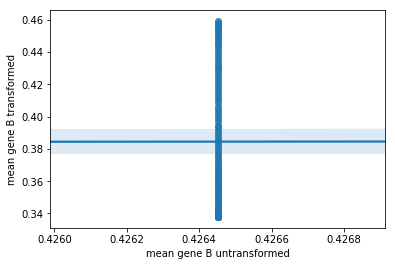

In [29]:
# Plot
sns.regplot(x='mean gene B untransformed',
            y='mean gene B transformed',
           data = original_B_vs_transformed_B_df)